In [1]:
import torch
from torch import Tensor

import matplotlib.colors as mplcolors

from pulser_diff.pulser import Sequence, Pulse, Register
from pulser_diff.pulser.devices import MockDevice
from pulser_diff.pulser.waveforms import RampWaveform, ConstantWaveform

import pulser_diff.dq as dq
from pulser_diff.backend import TorchEmulator
from pulser_diff.derivative import  deriv_param

from tqdm import tqdm

import matplotlib.pyplot as plt

from time import time

from pulser_diff.utils import kron

The purpose of this notebook is to roughly estimate the performance of both dynamiqs ODE solver and Krylov solver when simulating a simple pulse sequence consisting of a single time-dependent ramp pulse.

We investigate the dependence of calculation speed of both expectation value and the derivative of expectation value with respect to pulse parameter on number of qubits and timne sampling points.

In [2]:
def create_register(n_qubits: int) -> Register:
    return Register.rectangle(n_qubits, 1, spacing=200, prefix="q")

In [3]:
def create_sequence(reg: Register, omega: Tensor) -> Sequence:
    # create sequence and declare channels
    seq = Sequence(reg, MockDevice)
    seq.declare_channel("rydberg_global", "rydberg_global")

    # define pulse parameters
    omega_start = omega
    omega_end = 2 * omega

    # define time-dependent waveforms
    amp_wf = RampWaveform(1000, omega_start, omega_end)
    det_wf = ConstantWaveform(1000, 0.0)

    # add pulse
    seq.add(Pulse(amp_wf, det_wf, 0), "rydberg_global")

    return seq

In [4]:
def calculate_expectation(seq: Sequence, n_steps: int, solver: str, n_evals: int) -> tuple[Tensor, Tensor, float]:
    # generate evaluation times
    eval_times = torch.linspace(0.0, 1.0, n_steps)

    
    # simulate with dynamiqs ODE solver
    t1 = time()
    for _ in range(n_evals):
        sim = TorchEmulator.from_sequence(seq, evaluation_times=eval_times)
        results = sim.run(progress_bar=False, solver=solver)
    dt = (time() - t1) / n_evals

    # create total magnetization observable
    n_qubits = len(seq.register._coords)
    zero_sparse = torch.sparse_coo_tensor(
                        [[0], [0]],
                        [0],
                        (2**n_qubits, 2**n_qubits),
                        dtype=torch.complex128,
                    )
    total_magnetization = []
    for i in range(n_qubits):
        tprod = [dq.eye(2).to_sparse() for _ in range(n_qubits)]
        tprod[i] = dq.sigmaz().to_sparse()
        total_magnetization.append(kron(*tprod))
    total_magnetization = sum(total_magnetization, start=zero_sparse)

    # calculate expectation values
    exp_val = results.expect([total_magnetization])[0].real

    return eval_times, exp_val, dt

In [5]:
def simulate(n_qubits: int, n_steps: int, omega: Tensor, solver: str, n_evals: int = 1) -> tuple[Tensor, Tensor, float]:
    reg = create_register(n_qubits)
    seq = create_sequence(reg, omega)
    eval_times, exp_val, dt = calculate_expectation(seq, n_steps, solver, n_evals)
    return eval_times, exp_val, dt

### Compare expectation value calculation accuracy between dynamiqs and Krylov solvers

In [16]:
n_qubits = 4
n_steps = 100
omega = torch.tensor([10.0], requires_grad=True)

eval_times, exp_val_dq, dt_dq  = simulate(n_qubits, n_steps, omega, "dq", 1)
_, exp_val_kr, dt_kr = simulate(n_qubits, n_steps, omega, "krylov", 1)

In [17]:
def fx_theor(n_qubits: int, n_steps: int, omega: Tensor) -> Tensor:
    eval_times = torch.linspace(0.0, 1.0, n_steps)
    fx = -n_qubits*torch.cos(eval_times*omega*(1+eval_times/2))
    return fx


def dfdx_theor(n_qubits: int, n_steps: int, omega: Tensor) -> Tensor:
    eval_times = torch.linspace(0.0, 1.0, n_steps)
    dfdx_true = n_qubits*eval_times*(1+eval_times/2)*torch.sin(eval_times*omega*(1+eval_times/2))
    return dfdx_true

# calculate theoretical f(x) and df/dx values
fx_true = fx_theor(n_qubits, n_steps, omega)
dfdx_true = dfdx_theor(n_qubits, n_steps, omega)


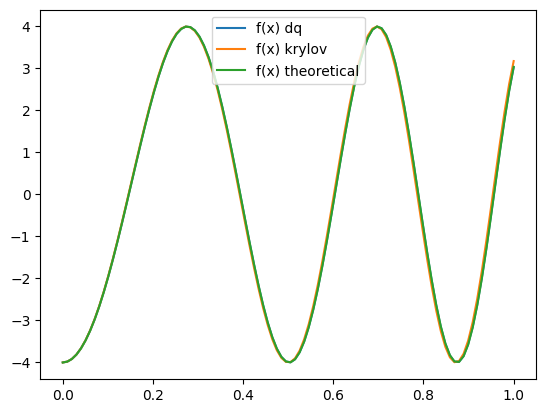

In [18]:
# visualize
plt.plot(eval_times.detach().numpy(), exp_val_dq.detach().numpy(), label="f(x) dq")
plt.plot(eval_times.detach().numpy(), exp_val_kr.detach().numpy(), label="f(x) krylov")
plt.plot(eval_times.detach().numpy(), fx_true.detach().numpy(), label="f(x) theoretical")
plt.legend()

### Compare derivative calculation accuracy between dynamiqs and Krylov solvers

In [20]:
times = torch.linspace(0.0, 1000.0, 40)

In [21]:
grads_dq = []
for t in tqdm(times):
    grad_param = deriv_param(f=exp_val_dq, x=omega, times=eval_times, t=t)
    grads_dq.append(torch.hstack(grad_param))
grads_dq = torch.stack(grads_dq)

100%|██████████| 40/40 [00:15<00:00,  2.66it/s]


In [22]:
grads_kr = []
for t in tqdm(times):
    grad_param = deriv_param(f=exp_val_kr, x=omega, times=eval_times, t=t)
    grads_kr.append(torch.hstack(grad_param))
grads_kr = torch.stack(grads_kr)

100%|██████████| 40/40 [00:05<00:00,  6.69it/s]


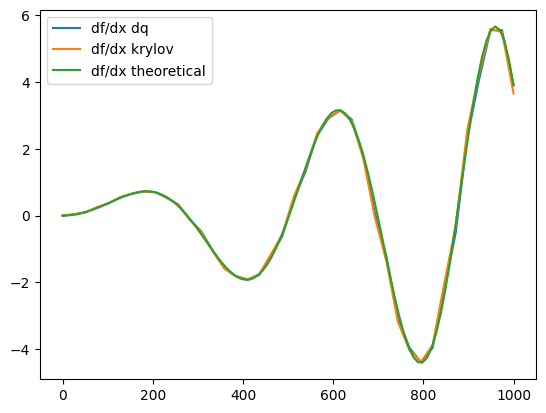

In [23]:
# visualize
plt.plot(times.detach().numpy(), grads_dq.detach().numpy(), label="df/dx dq")
plt.plot(times.detach().numpy(), grads_kr.detach().numpy(), label="df/dx krylov")
plt.plot(1000*eval_times.detach().numpy(), dfdx_true.detach().numpy(), label="df/dx theoretical")
plt.legend()

### Compare execution time between dynamiqs solver with Krylov solver

In [6]:
n_qubits_list = list(range(2, 11, 2))
n_steps_list = list(range(100, 1100, 200))
omega = torch.tensor([10.0], requires_grad=True)


#### Evaluating expectation value calculation speed

In [8]:
# test expectation value solution speed
dt_n_qubits_dq = []
dt_n_qubits_kr = []
for n in n_qubits_list:
    dt_n_steps_dq = []
    dt_n_steps_kr = []
    for s in n_steps_list:
        print(f"n_qubits={n}; n_steps={s}")
        # t1 = time()
        eval_times, exp_val_dq, dt = simulate(n, s, omega, "dq", n_evals=10)
        # dt = time() - t1
        dt_n_steps_dq.append(dt)
        print("dt dynamiqs:", dt)

        # t1 = time()
        eval_times, exp_val_kr, dt = simulate(n, s, omega, "krylov", n_evals=10)
        # dt = time() - t1
        dt_n_steps_kr.append(dt)
        print("dt krylov:", dt)
        print('-------------------')
        
    dt_n_qubits_dq.append(dt_n_steps_dq)
    dt_n_qubits_kr.append(dt_n_steps_kr)


n_qubits=2; n_steps=100
dt dynamiqs: 0.2343968152999878
dt krylov: 0.06704676151275635
-------------------
n_qubits=2; n_steps=300
dt dynamiqs: 0.42315833568572997
dt krylov: 0.19951975345611572
-------------------
n_qubits=2; n_steps=500
dt dynamiqs: 1.1891658782958985
dt krylov: 0.33454601764678954
-------------------
n_qubits=2; n_steps=700
dt dynamiqs: 1.0002192497253417
dt krylov: 0.4522613286972046
-------------------
n_qubits=2; n_steps=900
dt dynamiqs: 1.2779715538024903
dt krylov: 0.5759220361709595
-------------------
n_qubits=4; n_steps=100
dt dynamiqs: 0.3012341260910034
dt krylov: 0.1201866865158081
-------------------
n_qubits=4; n_steps=300
dt dynamiqs: 0.44775307178497314
dt krylov: 0.32926909923553466
-------------------
n_qubits=4; n_steps=500
dt dynamiqs: 0.8282009840011597
dt krylov: 0.5281088590621948
-------------------
n_qubits=4; n_steps=700
dt dynamiqs: 1.3882956027984619
dt krylov: 0.6845832586288452
-------------------
n_qubits=4; n_steps=900
dt dynamiqs: 1.4

In [16]:
# dynamiqs solver times
torch.as_tensor(dt_n_qubits_dq)

tensor([[0.2344, 0.4232, 1.1892, 1.0002, 1.2780],
        [0.3012, 0.4478, 0.8282, 1.3883, 1.4787],
        [0.4146, 0.5443, 1.0139, 1.7199, 2.3542],
        [1.2729, 1.0453, 1.5918, 2.3326, 2.9096],
        [3.2117, 3.3590, 4.8115, 7.6472, 8.8442]])

In [17]:
# krylov solver times
torch.as_tensor(dt_n_qubits_kr)

tensor([[0.0670, 0.1995, 0.3345, 0.4523, 0.5759],
        [0.1202, 0.3293, 0.5281, 0.6846, 0.7960],
        [0.1771, 0.4153, 0.6175, 0.8879, 1.0478],
        [0.2507, 0.5472, 0.8229, 1.0370, 1.3757],
        [0.5092, 0.9376, 1.3416, 1.7381, 2.2854]])

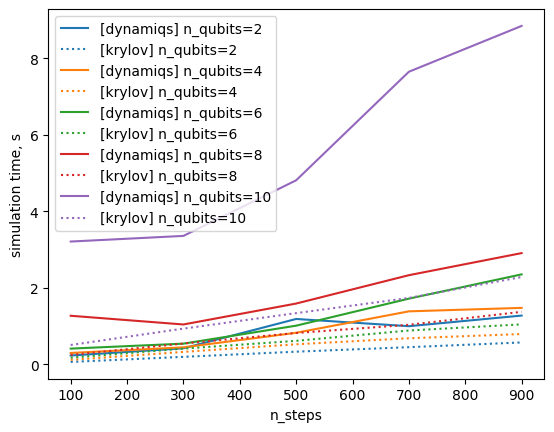

In [15]:
# visualize expectation value calculation time
colors = list(mplcolors.TABLEAU_COLORS.keys())
for i, n in enumerate(n_qubits_list):
    plt.plot(n_steps_list, dt_n_qubits_dq[i], linestyle="-", color=colors[i], label=f"[dynamiqs] n_qubits={n}")
    plt.plot(n_steps_list, dt_n_qubits_kr[i], linestyle=":", color=colors[i], label=f"[krylov] n_qubits={n}")
    plt.xlabel("n_steps")
    plt.ylabel("simulation time, s")

plt.legend()

#### Evaluating derivative calculation speed

In [6]:
n_qubits_list = list(range(2, 11, 2))
n_steps_list = [100, 500]
omega = torch.tensor([10.0], requires_grad=True)


In [7]:
times_deriv_eval = torch.linspace(0.0, 1000.0, 10)

In [8]:
# test expectation value solution speed
dt_n_qubits_deriv_dq = []
dt_n_qubits_deriv_kr = []
for n in n_qubits_list:
    dt_n_steps_deriv_dq = []
    dt_n_steps_deriv_kr = []
    for s in n_steps_list:
        print(f"n_qubits={n}; n_steps={s}")
        eval_times, exp_val_dq, _ = simulate(n, s, omega, "dq", n_evals=1)
        t1 = time()
        for t in times_deriv_eval:
            deriv_param(f=exp_val_dq, x=omega, times=eval_times, t=t)
        dt = (time() - t1) / len(times_deriv_eval)
        dt_n_steps_deriv_dq.append(dt)
        print("dt dynamiqs:", dt)

        # t1 = time()
        eval_times, exp_val_kr, dt = simulate(n, s, omega, "krylov", n_evals=1)
        t1 = time()
        for t in times_deriv_eval:
            deriv_param(f=exp_val_kr, x=omega, times=eval_times, t=t)
        dt = (time() - t1) / len(times_deriv_eval)
        dt_n_steps_deriv_kr.append(dt)
        print("dt krylov:", dt)
        print('-------------------')
        
    dt_n_qubits_deriv_dq.append(dt_n_steps_deriv_dq)
    dt_n_qubits_deriv_kr.append(dt_n_steps_deriv_kr)

n_qubits=2; n_steps=100
dt dynamiqs: 0.2818881988525391
dt krylov: 0.06797690391540527
-------------------
n_qubits=2; n_steps=500
dt dynamiqs: 1.1344800233840941
dt krylov: 0.4158447265625
-------------------
n_qubits=4; n_steps=100
dt dynamiqs: 0.47377839088439944
dt krylov: 0.1408113956451416
-------------------
n_qubits=4; n_steps=500
dt dynamiqs: 1.44373779296875
dt krylov: 0.7047556638717651
-------------------
n_qubits=6; n_steps=100
dt dynamiqs: 0.6495731592178344
dt krylov: 0.19914073944091798
-------------------
n_qubits=6; n_steps=500
dt dynamiqs: 1.5450694799423217
dt krylov: 0.7590011358261108
-------------------
n_qubits=8; n_steps=100
dt dynamiqs: 3.2924385547637938
dt krylov: 0.5810314893722535
-------------------
n_qubits=8; n_steps=500
dt dynamiqs: 6.891804194450378
dt krylov: 1.5203830242156982
-------------------
n_qubits=10; n_steps=100
dt dynamiqs: 34.72117509841919
dt krylov: 2.5359127044677736
-------------------
n_qubits=10; n_steps=500
dt dynamiqs: 68.89729423

In [9]:
# dynamiqs solver derivative calculation times
torch.as_tensor(dt_n_qubits_deriv_dq)

tensor([[ 0.2819,  1.1345],
        [ 0.4738,  1.4437],
        [ 0.6496,  1.5451],
        [ 3.2924,  6.8918],
        [34.7212, 68.8973]])

In [10]:
# krylov solver derivative calculation times
torch.as_tensor(dt_n_qubits_deriv_kr)

tensor([[0.0680, 0.4158],
        [0.1408, 0.7048],
        [0.1991, 0.7590],
        [0.5810, 1.5204],
        [2.5359, 5.0869]])

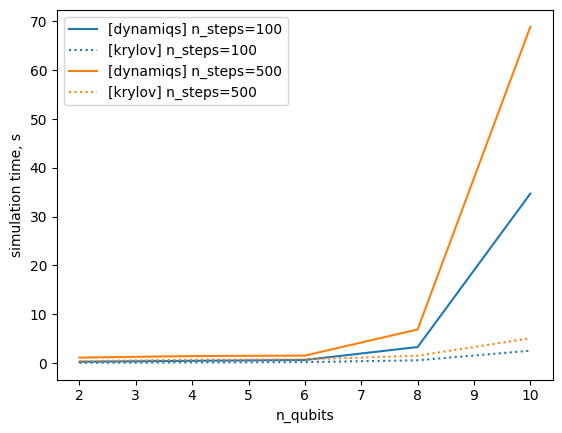

In [12]:
# visualize derivative calculation time
colors = list(mplcolors.TABLEAU_COLORS.keys())
for i, s in enumerate(n_steps_list):
    plt.plot(n_qubits_list, torch.as_tensor(dt_n_qubits_deriv_dq)[:,i], linestyle="-", color=colors[i], label=f"[dynamiqs] n_steps={s}")
    plt.plot(n_qubits_list, torch.as_tensor(dt_n_qubits_deriv_kr)[:,i], linestyle=":", color=colors[i], label=f"[krylov] n_steps={s}")
    plt.xlabel("n_qubits")
    plt.ylabel("simulation time, s")

plt.legend()